In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import networkx as nx
import os
import re

In [8]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/buoy"  

font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

TMAX = 200


Map 0.000


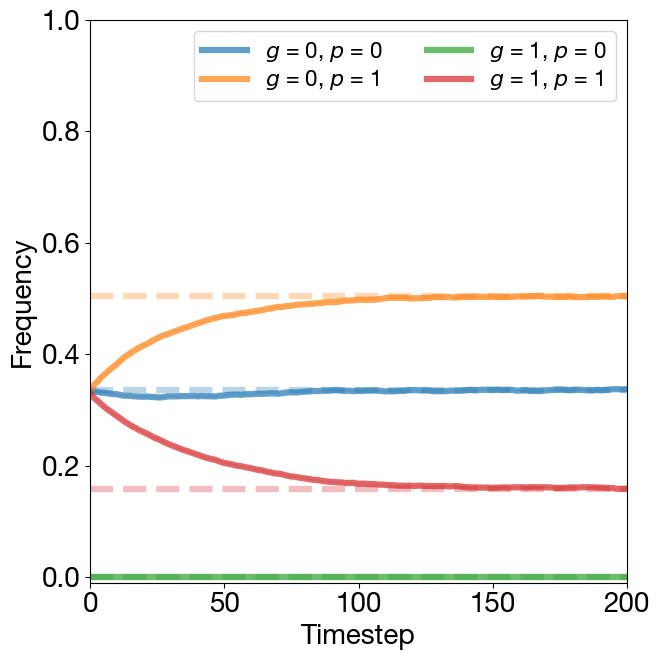

Map 0.100


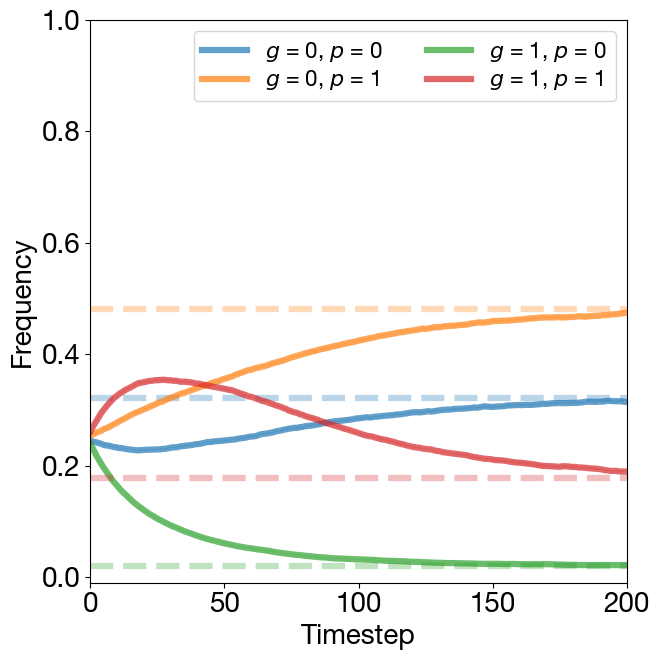

Map 0.200


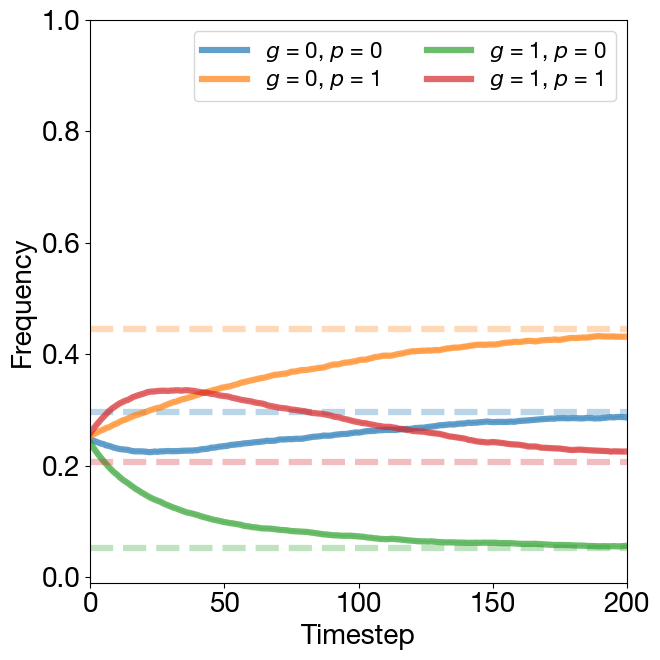

Map 0.300


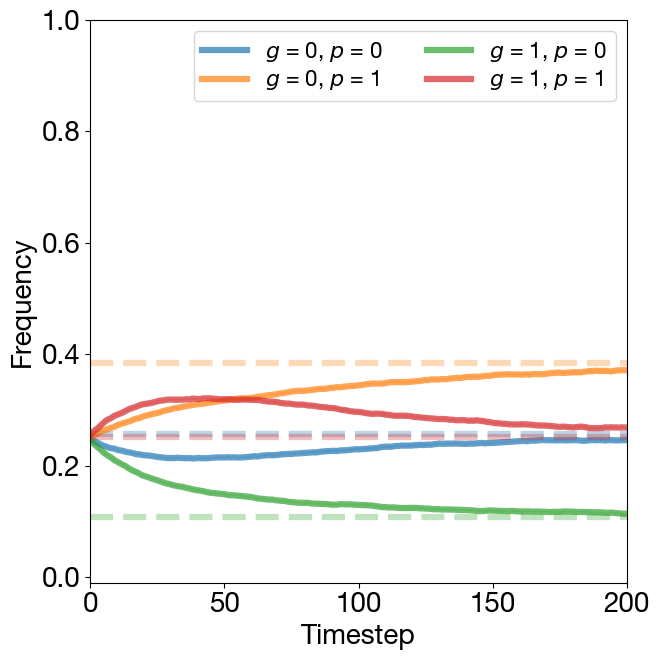

Map 0.400


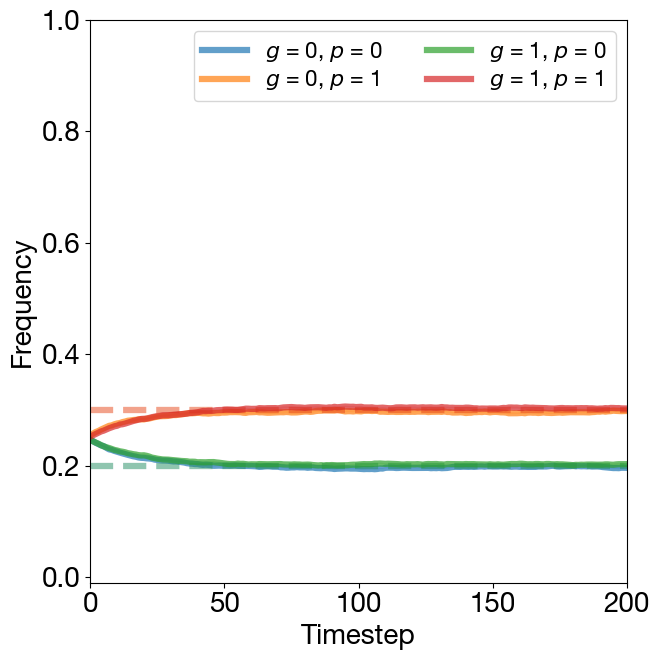

Map 0.500


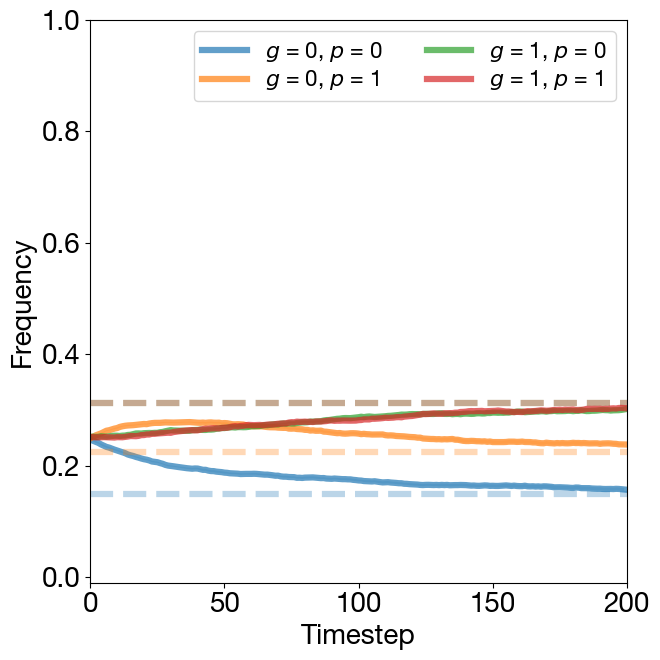

Map 0.600


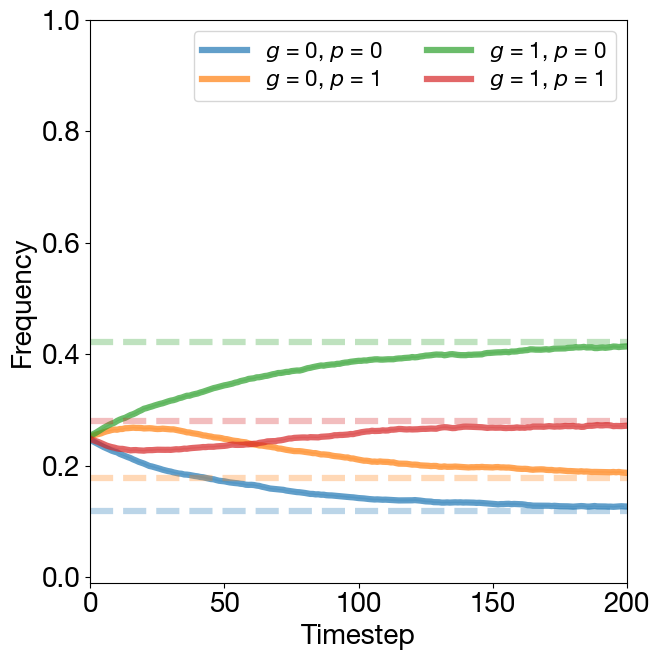

Map 0.700


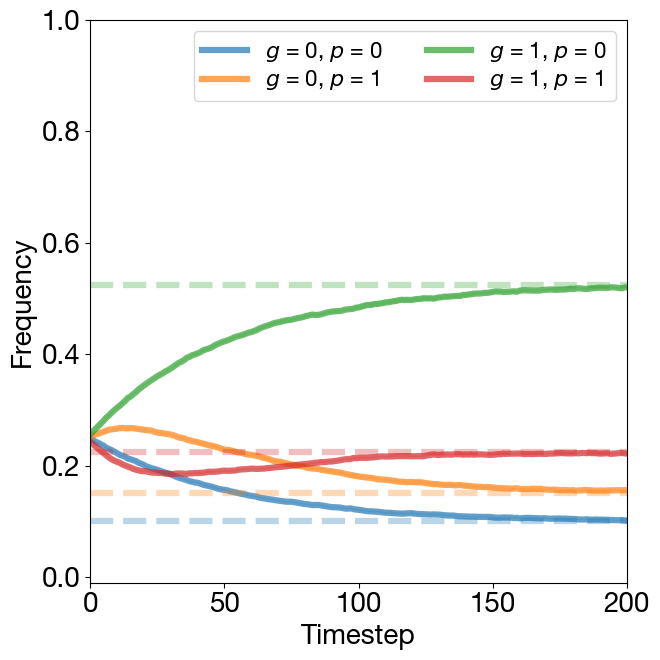

Map 0.800


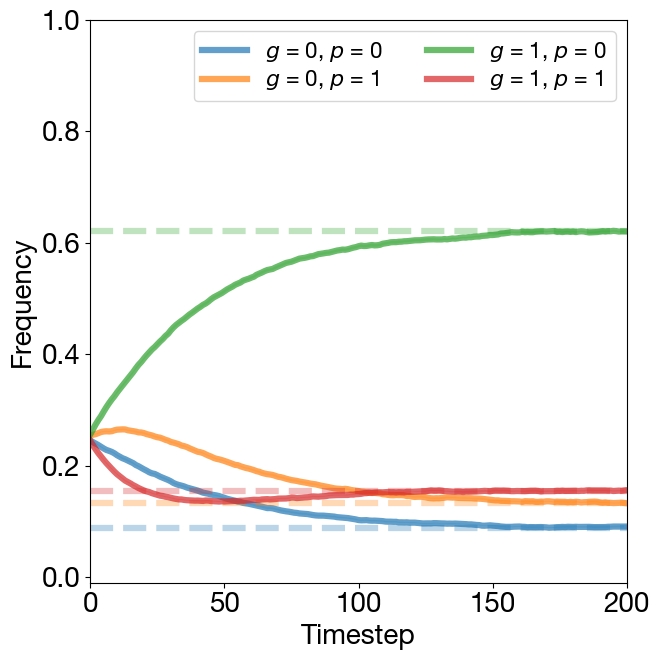

Map 0.900


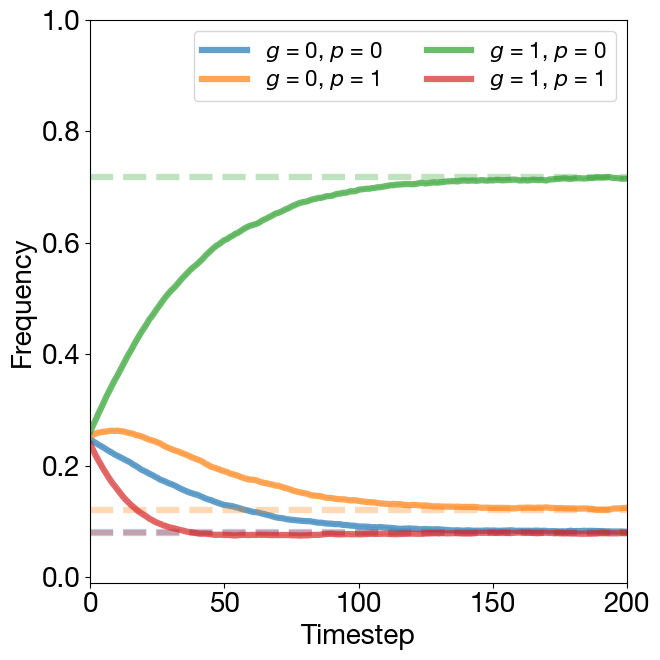

Map 1.000


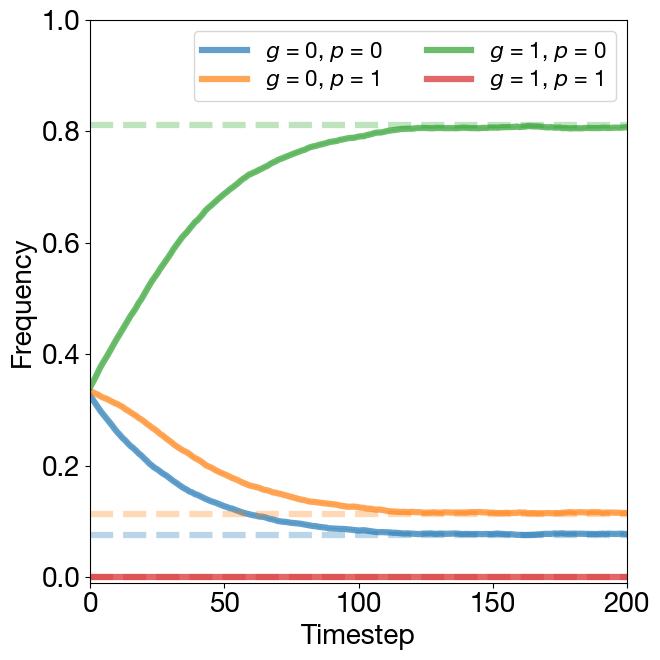

In [14]:
# Regex to extract map and trial
pattern = re.compile(r"sim_data_map_([0-9]+\.[0-9]+)_trial_([0-9]+)\.pkl")

# -----------------------------
# Build file dictionary: {map_val: {trial: filepath}}
# -----------------------------
files = [f for f in os.listdir(data_dir) if f.endswith(".pkl")]
file_dict = {}
for fname in files:
    match = pattern.match(fname)
    if match:
        map_val = float(match.group(1))
        trial = int(match.group(2))
        file_dict.setdefault(map_val, {})[trial] = os.path.join(data_dir, fname)

map_values = sorted(file_dict.keys())

# -----------------------------
# Plot mean ± SEM trajectories for each map
# -----------------------------
for map_val in map_values:
    trajs = []

    # Load trials
    for trial, fpath in sorted(file_dict[map_val].items()):
        with open(fpath, "rb") as fh:
            data = pickle.load(fh)
        freq_timeseries = np.array(data["freq_timeseries"])  # shape (2,2,timesteps)
        theoretical_vals = np.array(data['f_eq']).reshape(2,2) # same for all 
        trajs.append(freq_timeseries)

    trajs = np.stack(trajs, axis=0)  # (n_trials, 2, 2, timesteps)
    n_trials = trajs.shape[0]

    # Compute mean and SEM across trials
    mean_traj = trajs.mean(axis=0)       # (2, 2, timesteps)
    sem_traj = trajs.std(axis=0) / np.sqrt(n_trials)  # (2, 2, timesteps)

    timesteps = np.arange(TMAX)
    plt.figure(figsize=(7, 7))

    # Plot each (g,p) pair
    for i in range(2):
        for j in range(2):
            y = mean_traj[i, j, :TMAX]
            yerr = sem_traj[i, j, :TMAX]
            plt.plot(timesteps, y, label=f'$g$ = {i}, $p$ = {j}', alpha=0.7, linewidth=4.5)
            plt.fill_between(timesteps, y - yerr, y + yerr, alpha=0.2)

            # theoretical horizontal line
            th = theoretical_vals[i, j]
            plt.axhline(
                th, linestyle="--", linewidth=4.5,
                alpha=0.3, color=plt.gca().lines[-1].get_color()  # match curve color
            )

    # plt.title(f"Mean Trajectories ± SEM (map={map_val:.2f})")
    print(f"Map {map_val:.3f}")
    plt.xlabel("Timestep")
    plt.ylabel("Frequency")
    plt.ylim(-0.01, 1)
    plt.xlim(-0.1, TMAX)
    plt.legend(fontsize=16, loc="upper right", ncol=2, labelspacing=0.2)
    plt.tight_layout()
    plt.show()